In [1]:
import os
import json
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
root_dir = "../src/model_comparison"

methods = {
    "TreeTOp": "treetop",
    "NTopo": "ntopo",
    "SIMP": "SIMP_basic",
    "Ellipses": "Ellipses",
    "NeuralHeavisideSDF": "NHSDF",
    "NeuralHeavisideSDF (quadrangles)": "NHSDF_quad",
    "NeuralHeavisideSDF (triangles)": "NHSDF_triangle",
    "TopoDiff": "diffusion",
}

metrics_names = {
    "compliance": "C",
    "vf": "vf",
    "max_stress": r"$\text{vonMises}_{max}$",
}

free_form_methods_global = ["SIMP", "NTopo", "TopoDiff"]
fmto_methods_global = ["TreeTOp", "Ellipses", "NeuralHeavisideSDF", "NeuralHeavisideSDF (quadrangles)", "NeuralHeavisideSDF (triangles)"]

In [3]:

def load_result(method: str, task_name: str):
    """
    For a given method, construct the path to its result directory and try to locate
    a PNG file and a JSON file. Returns a tuple (png_file, json_file) or (None, None)
    if the directory or files do not exist.
    """
    result_dir = os.path.join(root_dir, methods[method])
    if not os.path.isdir(result_dir):
        print(f"Result directory {result_dir} does not exist")
        return None, None

    png_file = None
    json_file = None

    png_file = os.path.join(result_dir, f'{task_name}.png')
    json_file = os.path.join(result_dir, f'{task_name}.json')
    
    if os.path.isfile(png_file):
        return png_file, json_file
    else:
        return None, None


def plot_comparison(task_name: str, real_task_name: str, plot_params: dict, hilight_compliance: list[str], hilight_vonmises: list[str]) -> None:
    """
    Plot subplots comparing free-form methods (left column) and fmto methods (right column)
    for a given task. For each method, the function looks for a result directory at:
      root_dir/methods[method_name]/task_name
    and loads a PNG image (the plot) and a JSON file (the metrics). In each subplot,
    the left panel shows the image and the right panel displays the metrics.
    
    Parameters:
        task_name (str): The task name corresponding to the folder containing the results.
    """

    # Determine number of rows needed from the longer list of methods
    # result_dir = os.path.join(root_dir, methods[method])
    free_form_methods = [method for method in free_form_methods_global if os.path.exists(os.path.join(root_dir, methods[method], f'{task_name}.png'))]
    fmto_methods = [method for method in fmto_methods_global if os.path.exists(os.path.join(root_dir, methods[method], f'{task_name}.png'))]


    nrows_free = len(free_form_methods)
    nrows_fmto = len(fmto_methods)
    nrows = max(nrows_free, nrows_fmto)

    figsize_x = plot_params.get("figsize_x", 12)
    figsize_y_scale = plot_params.get("figsize_y_scale", 3)
    grid_wspace = plot_params.get("grid_wspace", 0.4)
    grid_hspace = plot_params.get("grid_hspace", 0.6)

    # Create a figure with two columns: left for free-form and right for fmto
    fig = plt.figure(figsize=(figsize_x, nrows * figsize_y_scale))
    outer_grid = gridspec.GridSpec(nrows, 2, wspace=grid_wspace, hspace=grid_hspace)

    # Add column titles for the two columns
    fig.text(0.25, 0.9, "Free-form methods", ha="center", va="bottom", fontsize=14, fontweight="bold")
    fig.text(0.75, 0.9, "FMTO methods", ha="center", va="bottom", fontsize=14, fontweight="bold")

    # Plot free-form methods in the left column (column index 0)
    for i in range(nrows):
        if i < len(free_form_methods):
            method = free_form_methods[i]
            # Create an inner grid with 1 row and 2 columns (image & metrics)
            inner_grid = gridspec.GridSpecFromSubplotSpec(
                1, 2, subplot_spec=outer_grid[i, 0], width_ratios=[3, 1], wspace=0.1
            )
            ax_img = fig.add_subplot(inner_grid[0])
            ax_text = fig.add_subplot(inner_grid[1])

            # ax_img.set_title(method, fontsize=12)
            png_file, json_file = load_result(method, task_name)
            if png_file and os.path.isfile(png_file):
                try:
                    img = plt.imread(png_file)
                    ax_img.imshow(img)
                except Exception as e:
                    ax_img.text(0.5, 0.5, f"Error loading image:\n{e}", ha='center', va='center')
            else:
                ax_img.text(0.5, 0.5, "No Image Available", ha='center', va='center')
            ax_img.axis('off')

            # Load and format the metrics from the JSON file
            metrics_text = f'$\\mathbf{{{method}}}$\n\n'
            if json_file and os.path.isfile(json_file):
                try:
                    with open(json_file, 'r') as f:
                        metrics = json.load(f)
                    for key, value in metrics.items():
                        try:
                            numeric_value = float(value)
                            formatted_value = f"{numeric_value:.3g}"
                        except (ValueError, TypeError):
                            if isinstance(value, list) and len(value) >= 2:
                                try:
                                    mean_val = float(value[0])
                                    std_val = float(value[1])
                                    if mean_val > 1e3:
                                        min_val = float(value[2])
                                        max_val = float(value[3])
                                        formatted_value = f"(min = {min_val:.3g}, max = {max_val:.3g})"
                                    else:
                                        formatted_value = f"{mean_val:.3g} $\\pm$ {std_val:.3g}"
                                except (ValueError, TypeError):
                                    formatted_value = str(value)
                            else:
                                formatted_value = str(value)

                        if method in hilight_compliance and key == "compliance":
                            formatted_value = f"$\\mathbf{{{formatted_value}}}$"
                        if method in hilight_vonmises and key == "max_stress":
                            formatted_value = f"$\\mathbf{{{formatted_value}}}$"
                        metrics_text += f"{metrics_names[key]}: {formatted_value}\n"
                except Exception as e:
                    metrics_text = f"Error loading metrics:\n{e}"
            else:
                metrics_text = "No Metrics Available"
            ax_text.text(0, 0.5, metrics_text, fontsize=10, va='center')
            ax_text.axis('off')
        else:
            # Create an empty subplot if there is no method for this row
            empty_ax = fig.add_subplot(outer_grid[i, 0])
            empty_ax.axis('off')

    # Plot fmto methods in the right column (column index 1)
    for i in range(nrows):
        if i < len(fmto_methods):
            method = fmto_methods[i]
            inner_grid = gridspec.GridSpecFromSubplotSpec(
                1, 2, subplot_spec=outer_grid[i, 1], width_ratios=[3, 1], wspace=0.1
            )
            ax_img = fig.add_subplot(inner_grid[0])
            ax_text = fig.add_subplot(inner_grid[1])

            # ax_img.set_title(method, fontsize=12)
            png_file, json_file = load_result(method, task_name)
            if png_file and os.path.isfile(png_file):
                try:
                    img = plt.imread(png_file)
                    ax_img.imshow(img)
                except Exception as e:
                    ax_img.text(0.5, 0.5, f"Error loading image:\n{e}", ha='center', va='center')
            else:
                ax_img.text(0.5, 0.5, "No Image Available", ha='center', va='center')
            ax_img.axis('off')

            metrics_text = f'$\\mathbf{{{method}}}$\n\n'
            if json_file and os.path.isfile(json_file):
                try:
                    with open(json_file, 'r') as f:
                        metrics = json.load(f)
                    for key, value in metrics.items():
                        try:
                            numeric_value = float(value)
                            formatted_value = f"{numeric_value:.3g}"
                        except (ValueError, TypeError):
                            if isinstance(value, list) and len(value) >= 2:
                                try:
                                    mean_val = float(value[0])
                                    std_val = float(value[1])
                                    if mean_val > 1e3:
                                        min_val = float(value[2])
                                        max_val = float(value[3])
                                        formatted_value = f"(min = {min_val:.3g}, max = {max_val:.3g})"
                                    else:
                                        formatted_value = f"{mean_val:.3g} $\\pm$ {std_val:.3g}"
                                except (ValueError, TypeError):
                                    formatted_value = str(value)
                            else:
                                formatted_value = str(value)
                        if method in hilight_compliance and key == "compliance":
                            formatted_value = f"$\\mathbf{{{formatted_value}}}$"
                        if method in hilight_vonmises and key == "max_stress":
                            formatted_value = f"$\\mathbf{{{formatted_value}}}$"
                        metrics_text += f"{metrics_names[key]}: {formatted_value}\n"
                except Exception as e:
                    metrics_text = f"Error loading metrics:\n{e}"
            else:
                metrics_text = "No Metrics Available"
            ax_text.text(0, 0.5, metrics_text, fontsize=10, va='center')
            ax_text.axis('off')
        else:
            empty_ax = fig.add_subplot(outer_grid[i, 1])
            empty_ax.axis('off')

    # Generate a LaTeX table summarizing metrics for each method

    table_rows = []
    all_metric_keys = set()

    for method in free_form_methods:
        _, json_file = load_result(method, task_name)
        method_metrics = {}
        if json_file and os.path.isfile(json_file):
            try:
                with open(json_file, 'r') as f:
                    metrics = json.load(f)
                for key, value in metrics.items():
                    all_metric_keys.add(key)
                    try:
                        numeric_value = float(value)
                        formatted_value = f"{numeric_value:.3g}"
                    except (ValueError, TypeError):
                        if isinstance(value, list) and len(value) >= 2:
                            try:
                                mean_val = float(value[0])
                                std_val = float(value[1])
                                if mean_val > 1e3:
                                    min_val = float(value[2])
                                    max_val = float(value[3])
                                    formatted_value = f"(min = {min_val:.3g}, max = {max_val:.3g})"
                                else:
                                    formatted_value = f"{mean_val:.3g} $\\pm$ {std_val:.3g}"
                            except (ValueError, TypeError):
                                formatted_value = str(value)
                        else:
                            formatted_value = str(value)

                    if key == "compliance" and method in hilight_compliance:
                        formatted_value = f"$\\textbf{{{formatted_value}}}$"
                    if key == "max_stress" and method in hilight_vonmises:
                        formatted_value = f"$\\textbf{{{formatted_value}}}$"
                    method_metrics[key] = formatted_value
            except Exception as e:
                # In case of error loading metrics, leave the dictionary empty
                method_metrics = {}
        table_rows.append((method, method_metrics))

    # Loop over each method to extract and format metrics
    for method in fmto_methods:
        _, json_file = load_result(method, task_name)
        method_metrics = {}
        if json_file and os.path.isfile(json_file):
            try:
                with open(json_file, 'r') as f:
                    metrics = json.load(f)
                # Process each metric: format numbers and apply bolding for compliance if needed
                for key, value in metrics.items():
                    all_metric_keys.add(key)
                    try:
                        numeric_value = float(value)
                        formatted_value = f"{numeric_value:.3g}"
                    except (ValueError, TypeError):
                        if isinstance(value, list) and len(value) >= 2:
                            try:
                                mean_val = float(value[0])
                                std_val = float(value[1])
                                if mean_val > 1e3:
                                    min_val = float(value[2])
                                    max_val = float(value[3])
                                    formatted_value = f"(min = {min_val:.3g}, max = {max_val:.3g})"
                                else:
                                    formatted_value = f"{mean_val:.3g} $\\pm$ {std_val:.3g}"
                            except (ValueError, TypeError):
                                formatted_value = str(value)
                        else:
                            formatted_value = str(value)
                    if key == "compliance" and method in hilight_compliance:
                        formatted_value = f"$\\textbf{{{formatted_value}}}$"
                    if key == "max_stress" and method in hilight_vonmises:
                        formatted_value = f"$\\textbf{{{formatted_value}}}$"
                    method_metrics[key] = formatted_value
            except Exception as e:
                # In case of error loading metrics, leave the dictionary empty
                method_metrics = {}
        table_rows.append((method, method_metrics))
    
    # Determine a consistent column order based on the available metric keys.
    # Use the human-readable names from metrics_names if available.
    metric_keys = sorted(list(all_metric_keys), key=lambda k: metrics_names.get(k, k))
    
    # Create header row: first column is "Method", then metric names
    header = ["Method", "Method type"] + [metrics_names.get(k, k) for k in metric_keys]
    num_cols = len(header)
    # Build the Markdown table string
    markdown_table = ""
    # Create header row using Markdown syntax
    markdown_table += "| " + " | ".join(header) + " |\n"
    # Create separator row: first column left-aligned, others center-aligned
    alignments = [":---"] + [":---:" for _ in range(num_cols - 1)]
    markdown_table += "| " + " | ".join(alignments) + " |\n"
    for method, m_metrics in table_rows:
        method_type = "Free-form" if method in free_form_methods else "FMTO"
        row = [method, method_type] + [m_metrics.get(k, "N/A") for k in metric_keys]
        markdown_table += "| " + " | ".join(row) + " |\n"
        # if method == "NTopo":
        #     markdown_table += "| " + " | ".join(alignments) + " |\n"
    # Append a caption below the table as a note
    markdown_table += "\nTable: Methods comparison for " + real_task_name + "\n"
    # Output the generated LaTeX table
    print(markdown_table)

    plt.tight_layout()
    plt.savefig(os.path.join(root_dir, f"{task_name}.png"), dpi=300, bbox_inches='tight')
    plt.show()


In [5]:
def generate_latex_comparison_table(tasks, method_names, metrics_dir, wide=False):
    """
    Iterates over configuration names, loads metrics, and prints a LaTeX formatted comparison table.

    Parameters:
        configs (list of str): List of configuration names (e.g. ["Task1", "Task2", "Task3", "Task4"]).
                               Each config is expected to have a corresponding JSON file named '<config>_metrics.json'.
        metrics_dir (str): Directory path where the metrics JSON files are stored.
    
    Expected JSON structure for each metrics file:
        {
            "MethodName1": {"vf": value, "C": value, ...},
            "MethodName2": {"vf": value, "C": value, ...},
            ...
        }
    
    The resulting LaTeX table has methods as rows and tasks (configurations) as columns.
    Each table cell is formatted as:
        \\makecell[r]{<formatted vf> \\\\ <formatted C>}
        
    For example, if the method is 'SIMP' or 'Ellips.', the values are highlighted:
        'SIMP'   → highlighted in OliveGreen
        'Ellips.'→ highlighted in red
    Other methods are printed without extra color formatting.
    """
    import os, json  # Local imports for file operations and JSON parsing

    # Aggregate metrics for each method across configurations
    # comparison_data structure: { method: { config: { "vf": ..., "C": ... } } }
    comparison_data = {}

    for method in method_names:
        method_dir = os.path.join(metrics_dir, methods[method])
        comparison_data[method] = {}
        for task_name in tasks:
            metrics_file = os.path.join(method_dir, f"{task_name}.json")
            try:
                with open(metrics_file, 'r') as f:
                    config_metrics = json.load(f)
                comparison_data[method][task_name] = config_metrics
            except Exception as e:
                print(f"Warning: Could not load metrics for config '{method} {task_name}': {e}")
                continue

    # Compute best compliance ("C") metrics for free_form_methods and fmto methods separately for each task
    best_compliance_free = {task: None for task in tasks}
    best_compliance_fmto = {task: None for task in tasks}
    for method, task_data in comparison_data.items():
        
        for task in tasks:
            if task in task_data:
                comp = task_data[task].get("compliance", None)
                try:
                    comp_val = float(comp)
                except (ValueError, TypeError):
                    continue
                # Check membership in free_form_methods if available; otherwise treat as fmto
                if method in free_form_methods_global:
                    if best_compliance_free[task] is None or comp_val < best_compliance_free[task]:
                        best_compliance_free[task] = comp_val
                else:
                    if best_compliance_fmto[task] is None or comp_val < best_compliance_fmto[task]:
                        best_compliance_fmto[task] = comp_val


    # Build LaTeX table
    num_tasks = len(tasks)
    if wide:
        header_tasks = ["Method type"] + [f"Task {i+1}" for i in range(num_tasks)]
        num_tasks += 1
    else:
        header_tasks = [f"Task {i+1}" for i in range(num_tasks)]
    latex_table = "\\renewcommand{\\arraystretch}{2.0} % Default value: 1\n"
    latex_table += "\\renewcommand\\cellset{\\renewcommand\\arraystretch{0.7}}%\n"
    if wide:
        latex_table += "\\setlength{\\tabcolsep}{4pt} % Default value: 6pt\n"
        latex_table += "\\begin{table*}[ht]\n"
    else:
        latex_table += "\\begin{table}[ht]\n"
    latex_table += "    \\caption{Comparison of different topology optimization methods via \textbf{Compliance} metric.}\n"
    latex_table += "    \\vskip 0.1in\n"
    latex_table += "    \\centering\n"
    # latex_table += "    \\begin{small}\n"
    latex_table += "    \\label{tab:topo_optimization}\n"
    latex_table += "    \\begin{tabular}{l@{\hskip 0.01in}" + "c@{\hskip 0.01in}" + "c" * (num_tasks - 1) + "}\n"
    
    # Header row: first column empty, then task names
    header_line = " & ".join(["Method"] + header_tasks) + " \\\\\n"
    latex_table += "        " + header_line
    latex_table += "        \\midrule\n"

    # Iterate over each method (sorted for consistency) to create table rows
    for method in comparison_data.keys():
        if method in ["NeuralHeavisideSDF", "NeuralHeavisideSDF (quadrangles)", "NeuralHeavisideSDF (triangles)"]:
            first_str_row  = "NHSDF-TOp"
            second_str_row = ""
            if method.split(" ")[-1] == "(quadrangles)":
                second_str_row = "(Quad) "
            if method.split(" ")[-1] == "(triangles)":
                second_str_row = "(Triangl) "
            second_str_row += "(Ours)"
            row_cells = [f"\\makecell[l]{{NHSDF-TOp \\\\ {second_str_row}}}"]
        else:
            row_cells = [method]
        if wide:
            row_cells.append("Free-form" if method in free_form_methods_global else "FMTO")
        for task_name in tasks:
            if task_name in comparison_data[method]:
                m_metrics = comparison_data[method][task_name]
                # Extract 'vf' and 'compliance' metrics, defaulting to "--" if missing
                vf = m_metrics.get("vf", "--")
                comp = m_metrics.get("compliance", "--")
                try:
                    vf_val = float(vf)
                    vf_str = f"{vf_val:.3g}"
                except:
                    if isinstance(vf, list):
                        vf_val = float(vf[0])
                        vf_str = f"{vf_val:.3g}"
                    else:
                        vf_str = str(vf)

                try:
                    comp_val = float(comp)
                    comp_str = f"{comp_val:.3g}"
                except:
                    if isinstance(comp, list):
                        comp_val = float(comp[0])
                        comp_str = f"{comp_val:.3g}"
                    else:
                        comp_str = str(comp)
                
                # Format the string for vf
                if wide:
                    vf_str = f"vf={vf_str}"
                else:
                    vf_str = f"vf={vf_str}"
                
                try:
                    comp_str = f"{comp_val:.2e}"
                except Exception:
                    comp_str = str(comp)

                # Bold the best compliance value for each group (free_form_methods vs fmto)
                if method in free_form_methods_global:
                    if best_compliance_free[task_name] is not None and abs(comp_val - best_compliance_free[task_name]) < 1e-8:
                        comp_str = f"\\textbf{{{comp_str}}}"
                else:
                    if best_compliance_fmto[task_name] is not None and abs(comp_val - best_compliance_fmto[task_name]) < 1e-8:
                        comp_str = f"\\textbf{{{comp_str}}}"
                comp_str = f"{comp_str}"
                
                cell = f"\\makecell[r]{{{comp_str} \\\\ ({vf_str})}}"
            else:
                cell = "N/A"
            row_cells.append(cell)
        latex_table += "        " + " & ".join(row_cells) + " \\\\\n"

        if method == "NTopo":
            latex_table += "        \\midrule\n"

    latex_table += "        \\midrule\n"
    latex_table += "    \\end{tabular}\n"
    # latex_table += "    \\end{small}\n"
    latex_table += "    \\vskip -0.1in\n"
    if wide:
        latex_table += "\\end{table*}\n"
    else:
        latex_table += "\\end{table}\n"
    
    print(latex_table)

# configs = ["MBB_beam_half", "Cant_beam", "Cant_beam_distrL", "Brecket"]
tasks_list = ["Cant_beam", "Brecket", "MBB_beam_half", "Cant_beam_distrL", "Square_cantilever_beam", "Square_beam"]
methods_list = ["SIMP", "TopoDiff", "NTopo", "Ellipses", "TreeTOp", "NeuralHeavisideSDF", "NeuralHeavisideSDF (quadrangles)", "NeuralHeavisideSDF (triangles)"]

metrics_dir = "../src/model_comparison"
generate_latex_comparison_table(tasks_list, methods_list, metrics_dir, wide=True)


\renewcommand{\arraystretch}{2.0} % Default value: 1
\renewcommand\cellset{\renewcommand\arraystretch{0.7}}%
\setlength{\tabcolsep}{4pt} % Default value: 6pt
\begin{table*}[ht]
    \caption{Comparison of different topology optimization methods via 	extbf{Compliance} metric.}
    \vskip 0.1in
    \centering
    \label{tab:topo_optimization}
    \begin{tabular}{l@{\hskip 0.01in}c@{\hskip 0.01in}cccccc}
        Method & Method type & Task 1 & Task 2 & Task 3 & Task 4 & Task 5 & Task 6 \\
        \midrule
        SIMP & Free-form & \makecell[r]{\textbf{3.78e-05} \\ (vf=0.254)} & \makecell[r]{\textbf{1.42e-03} \\ (vf=0.36)} & \makecell[r]{\textbf{1.25e-03} \\ (vf=0.44)} & \makecell[r]{\textbf{1.04e-04} \\ (vf=0.34)} & \makecell[r]{\textbf{1.51e+01} \\ (vf=0.41)} & \makecell[r]{\textbf{2.21e+01} \\ (vf=0.41)} \\
        TopoDiff & Free-form & N/A & N/A & N/A & N/A & \makecell[r]{1.70e+01 \\ (vf=0.424)} & \makecell[r]{2.44e+01 \\ (vf=0.415)} \\
        NTopo & Free-form & \makecell[r]{4.08e-0

<>:85: SyntaxWarning: invalid escape sequence '\h'
<>:85: SyntaxWarning: invalid escape sequence '\h'
<>:85: SyntaxWarning: invalid escape sequence '\h'
<>:85: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipykernel_5522/2764375146.py:85: SyntaxWarning: invalid escape sequence '\h'
  latex_table += "    \\begin{tabular}{l@{\hskip 0.01in}" + "c@{\hskip 0.01in}" + "c" * (num_tasks - 1) + "}\n"
/tmp/ipykernel_5522/2764375146.py:85: SyntaxWarning: invalid escape sequence '\h'
  latex_table += "    \\begin{tabular}{l@{\hskip 0.01in}" + "c@{\hskip 0.01in}" + "c" * (num_tasks - 1) + "}\n"


In [48]:
def plot_comparison_one_column(task_name: str, real_task_name: str, plot_params: dict, hilight_compliance: list[str], hilight_vonmises: list[str], 
                               methods_for_plot: list[str] = None) -> None:
    """
    Plot subplots comparing free-form methods (left column) and fmto methods (right column)
    for a given task. For each method, the function looks for a result directory at:
      root_dir/methods[method_name]/task_name
    and loads a PNG image (the plot) and a JSON file (the metrics). In each subplot,
    the left panel shows the image and the right panel displays the metrics.
    
    Parameters:
        task_name (str): The task name corresponding to the folder containing the results.
    """

    # Determine number of rows needed from the longer list of methods
    # result_dir = os.path.join(root_dir, methods[method])
    free_form_methods = [method for method in free_form_methods_global if os.path.exists(os.path.join(root_dir, methods[method], f'{task_name}.png'))]
    fmto_methods = [method for method in fmto_methods_global if os.path.exists(os.path.join(root_dir, methods[method], f'{task_name}.png'))]
    one_column_methods = free_form_methods + fmto_methods

    if methods_for_plot is not None:
        one_column_methods = [method for method in one_column_methods if method in methods_for_plot]

    # nrows_free = len(free_form_methods)
    # nrows_fmto = len(fmto_methods)
    # nrows = max(nrows_free, nrows_fmto)
    nrows = len(one_column_methods)

    figsize_x = plot_params.get("figsize_x", 12)
    figsize_y_scale = plot_params.get("figsize_y_scale", 3)
    grid_wspace = plot_params.get("grid_wspace", 0.4)
    grid_hspace = plot_params.get("grid_hspace", 0.6)

    # Create a figure with two columns: left for free-form and right for fmto
    fig = plt.figure(figsize=(figsize_x, nrows * figsize_y_scale))
    outer_grid = gridspec.GridSpec(nrows, 1, wspace=grid_wspace, hspace=grid_hspace)

    # Add column titles for the two columns
    # fig.text(0.25, 0.9, "Free-form methods", ha="center", va="bottom", fontsize=14, fontweight="bold")
    # fig.text(0.75, 0.9, "FMTO methods", ha="center", va="bottom", fontsize=14, fontweight="bold")

    # Plot free-form methods in the left column (column index 0)
    for i in range(nrows):
        if i < len(one_column_methods):
            method = one_column_methods[i]
            # Create an inner grid with 1 row and 2 columns (image & metrics)
            inner_grid = gridspec.GridSpecFromSubplotSpec(
                1, 2, subplot_spec=outer_grid[i, 0], width_ratios=[3, 1], wspace=0.1
            )
            ax_img = fig.add_subplot(inner_grid[0])
            ax_text = fig.add_subplot(inner_grid[1])

            # ax_img.set_title(method, fontsize=12)
            png_file, json_file = load_result(method, task_name)
            if png_file and os.path.isfile(png_file):
                try:
                    img = plt.imread(png_file)
                    ax_img.imshow(img)
                except Exception as e:
                    ax_img.text(0.5, 0.5, f"Error loading image:\n{e}", ha='center', va='center')
            else:
                ax_img.text(0.5, 0.5, "No Image Available", ha='center', va='center')
            ax_img.axis('off')

            # Load and format the metrics from the JSON file
            if method in ["NeuralHeavisideSDF", "NeuralHeavisideSDF (quadrangles)", "NeuralHeavisideSDF (triangles)"]:
                first_str_row  = "NHSDF-TOp"
                second_str_row = ""
                if method.split(" ")[-1] == "(quadrangles)":
                    second_str_row = "(Quad) "
                if method.split(" ")[-1] == "(triangles)":
                    second_str_row = "(Triangl) "
                second_str_row += "(Ours)"
                metrics_text = f'$\\mathbf{{NHSDF-TOp}}$\n $\\mathbf{{{second_str_row}}}$\n\n'
            else:
                metrics_text = f'$\\mathbf{{{method}}}$\n\n'
            if json_file and os.path.isfile(json_file):
                try:
                    with open(json_file, 'r') as f:
                        metrics = json.load(f)
                    for key, value in metrics.items():
                        try:
                            numeric_value = float(value)
                            formatted_value = f"{numeric_value:.3g}"
                        except (ValueError, TypeError):
                            if isinstance(value, list) and len(value) >= 2:
                                try:
                                    mean_val = float(value[0])
                                    std_val = float(value[1])
                                    if mean_val > 1e3:
                                        min_val = float(value[2])
                                        max_val = float(value[3])
                                        formatted_value = f"(min = {min_val:.3g}, max = {max_val:.3g})"
                                    else:
                                        formatted_value = f"{mean_val:.3g} $\\pm$ {std_val:.3g}"
                                except (ValueError, TypeError):
                                    formatted_value = str(value)
                            else:
                                formatted_value = str(value)

                        if method in hilight_compliance and key == "compliance":
                            formatted_value = f"$\\mathbf{{{formatted_value}}}$"
                        if method in hilight_vonmises and key == "max_stress":
                            formatted_value = f"$\\mathbf{{{formatted_value}}}$"
                        metrics_text += f"{metrics_names[key]}: {formatted_value}\n"
                except Exception as e:
                    metrics_text = f"Error loading metrics:\n{e}"
            else:
                metrics_text = "No Metrics Available"
            ax_text.text(0, 0.5, metrics_text, fontsize=10, va='center')
            ax_text.axis('off')
        else:
            # Create an empty subplot if there is no method for this row
            empty_ax = fig.add_subplot(outer_grid[i, 0])
            empty_ax.axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(root_dir, f"{task_name}.png"), dpi=300, bbox_inches='tight')
    print(os.path.join(root_dir, f"{task_name}.png"))
    plt.show()


/tmp/ipykernel_5522/4160991007.py:116: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


../src/model_comparison/Cant_beam_distrL.png


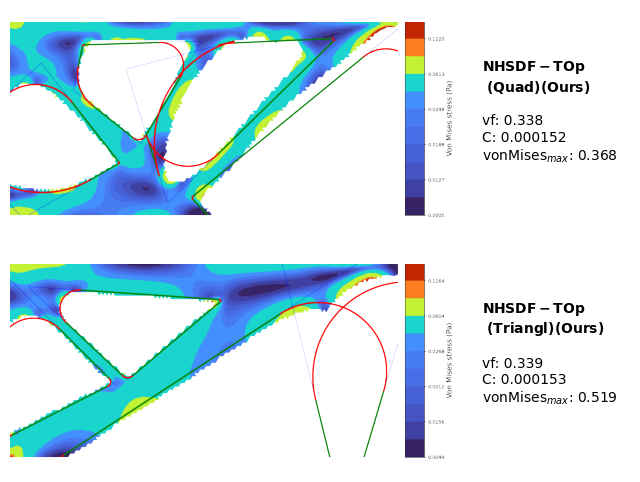

In [53]:
# config_name = "MBB_beam_half" #
# config_name = "Cant_beam"
config_name = "Cant_beam_distrL"
# config_name = "Brecket"

# config_name = "Square_beam"
# config_name = "Square_beam_distrL"
# config_name = "Square_cantilever_beam"

# plot_params = {"figsize_x": 8, "figsize_y_scale": 4,
#                "grid_wspace": 0.3,
#                "grid_hspace": 0.1}

plot_params = {"figsize_x": 8, "figsize_y_scale": 3,
               "grid_wspace": 0.1,
               "grid_hspace": 0.1}


# hilight_compliance = ["NTopo", "NeuralHeavisideSDF"]
# hilight_vonmises = ["SIMP", "Ellipses"]

hilight_compliance = ["SIMP"]
hilight_vonmises = ["SIMP"]

real_task_names = {
    "MBB_beam_half": "MBB beam half",
    "Cant_beam": "Cantilever beam",
    "Cant_beam_distrL": "Beam Distributed Load",
    "Brecket": "Bracket",
    "Square_beam": "Square beam",
    "Square_beam_distrL": "Square beam Distributed Load",
    "Square_cantilever_beam": "Square cantilever beam",
}

# methods_for_plot = ["SIMP", 'Ellipses', 'NeuralHeavisideSDF', 'NeuralHeavisideSDF (quadrangles)', 'NeuralHeavisideSDF (triangles)']
methods_for_plot = ['NeuralHeavisideSDF (quadrangles)', 'NeuralHeavisideSDF (triangles)']

# plot_comparison(config_name, real_task_names[config_name], plot_params, hilight_compliance, hilight_vonmises)
plot_comparison_one_column(config_name,
                           real_task_names[config_name],
                           plot_params,
                           hilight_compliance,
                           hilight_vonmises,
                           methods_for_plot)

| Method | Method type | $\text{vonMises}_{max}$ | C | vf |
| :--- | :---: | :---: | :---: | :---: |
| SIMP | Free-form | $\textbf{0.483}$ | $\textbf{0.00125}$ | 0.44 |
| NTopo | Free-form | 2.52 | 0.00163 | 0.438 |
| TreeTOp | FMTO | 6.08 | 0.00373 | 0.455 |
| Ellipses | FMTO | 0.607 | 0.00174 | 0.449 |
| NeuralHeavisideSDF | FMTO | $\textbf{0.522}$ | $\textbf{0.00163}$ | 0.437 |

*Methods comparison for MBB beam half*



/tmp/ipykernel_11835/2121781048.py:238: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


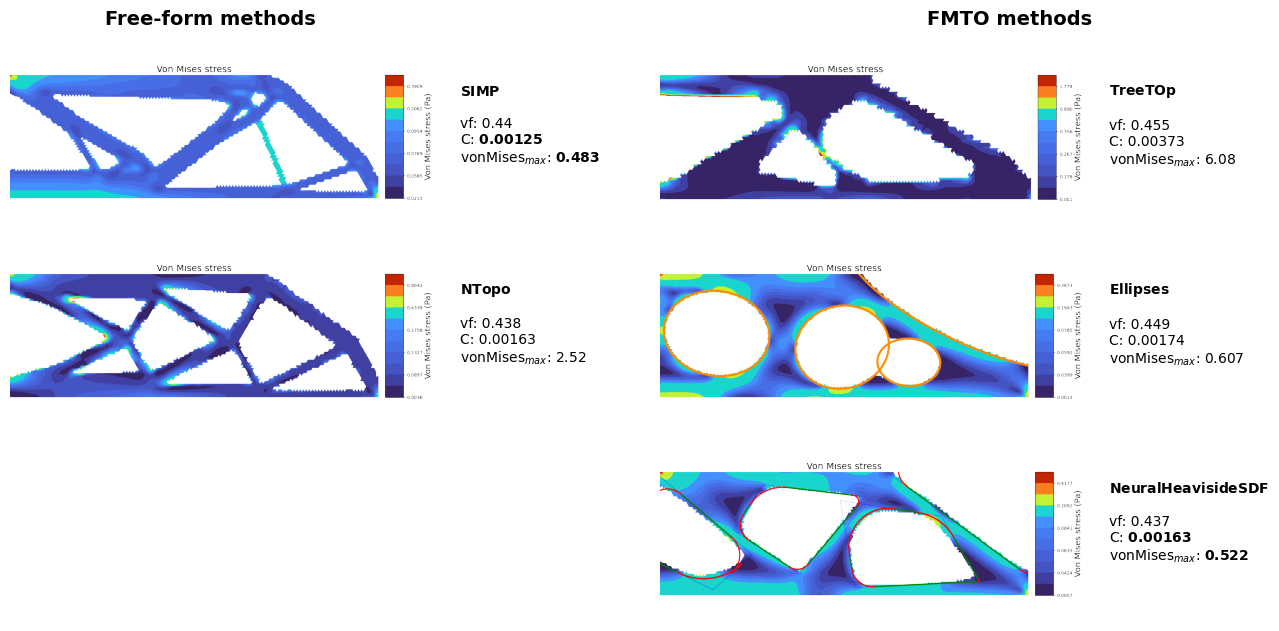

In [35]:
config_name = "MBB_beam_half" #
# config_name = "Cant_beam"
# config_name = "Cant_beam_distrL"
# config_name = "Brecket"

plot_params = {"figsize_x": 16, "figsize_y_scale": 2.5,
               "grid_wspace": 0.1,
               "grid_hspace": 0.1}

hilight_compliance = ["SIMP", "NeuralHeavisideSDF"]
hilight_vonmises = ["SIMP", "NeuralHeavisideSDF"]

plot_comparison(config_name, real_task_names[config_name], plot_params, hilight_compliance, hilight_vonmises)

| Method | Method type | $\text{vonMises}_{max}$ | C | vf |
| :--- | :---: | :---: | :---: | :---: |
| SIMP | Free-form | $\textbf{0.194}$ | $\textbf{0.000104}$ | 0.34 |
| NTopo | Free-form | 0.349 | 0.000107 | 0.339 |
| TreeTOp | FMTO | 43.8 | 0.000155 | 0.357 |
| Ellipses | FMTO | 0.674 | 0.000155 | 0.345 |
| NeuralHeavisideSDF | FMTO | $\textbf{0.575}$ | $\textbf{0.000152}$ | 0.337 |

*Methods comparison for Beam Distributed Load*



/tmp/ipykernel_11835/2121781048.py:238: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


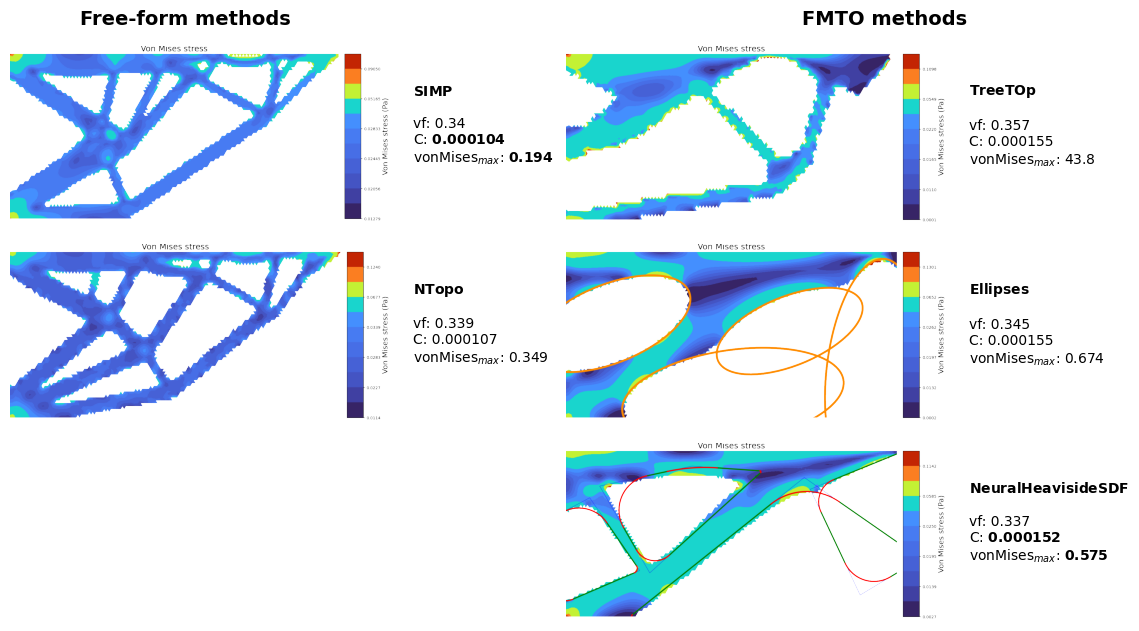

In [36]:
# config_name = "MBB_beam_half" #
# config_name = "Cant_beam"
config_name = "Cant_beam_distrL"
# config_name = "Brecket"

plot_params = {"figsize_x": 14, "figsize_y_scale": 2.5,
               "grid_wspace": 0.05,
               "grid_hspace": 0.1}

hilight_compliance = ["SIMP", "NeuralHeavisideSDF"]
hilight_vonmises = ["SIMP", "NeuralHeavisideSDF"]

plot_comparison(config_name, real_task_names[config_name], plot_params, hilight_compliance, hilight_vonmises)

| Method | Method type | $\text{vonMises}_{max}$ | C | vf |
| :--- | :---: | :---: | :---: | :---: |
| SIMP | Free-form | $\textbf{0.41}$ | $\textbf{0.00142}$ | 0.36 |
| Ellipses | FMTO | 0.956 | 0.00222 | 0.368 |
| NeuralHeavisideSDF | FMTO | $\textbf{0.442}$ | $\textbf{0.0017}$ | 0.354 |

*Methods comparison for Bracket*



/tmp/ipykernel_11835/2121781048.py:238: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


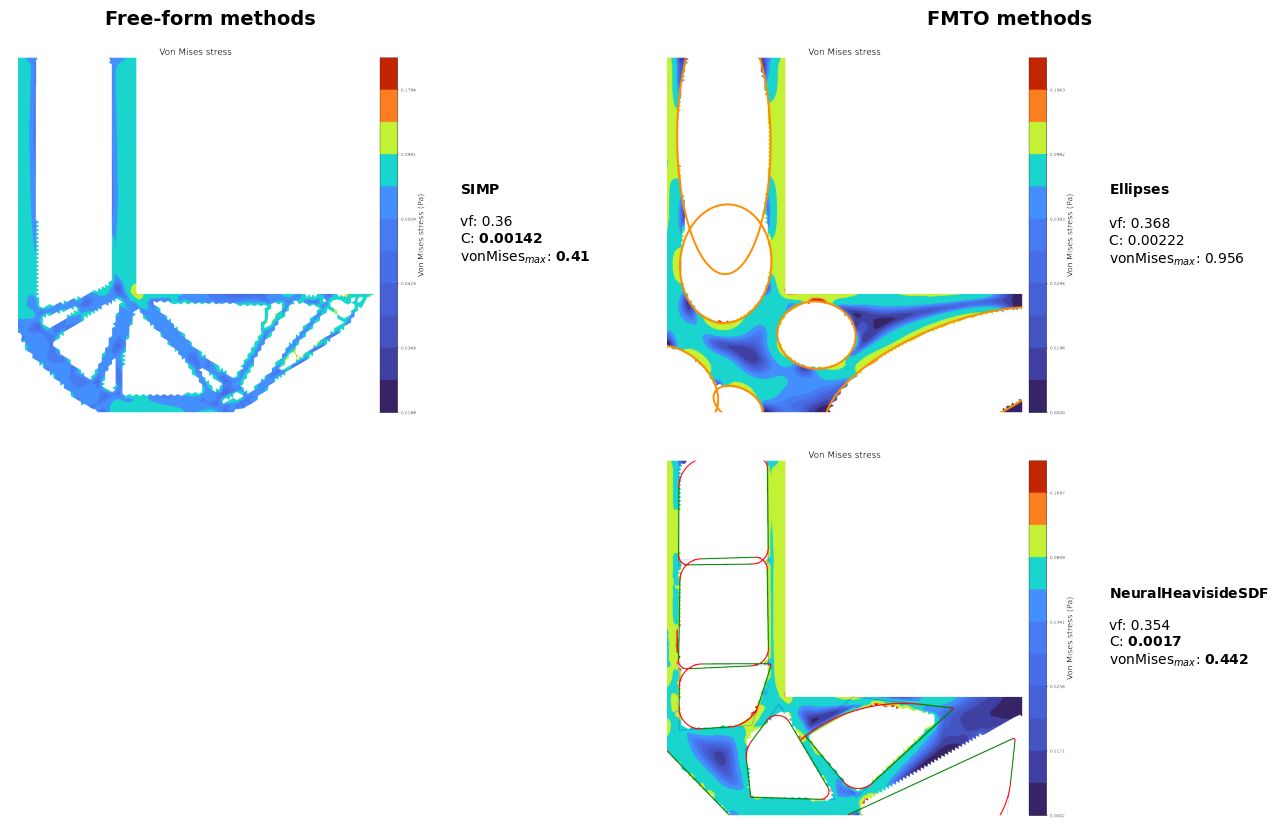

In [39]:
# config_name = "MBB_beam_half" #
# config_name = "Cant_beam"
# config_name = "Cant_beam_distrL"
config_name = "Brecket"

plot_params = {"figsize_x": 16, "figsize_y_scale": 5,
               "grid_wspace": 0.1,
               "grid_hspace": 0.1}

hilight_compliance = ["SIMP", "NeuralHeavisideSDF"]
hilight_vonmises = ["SIMP", "NeuralHeavisideSDF"]

plot_comparison(config_name, real_task_names[config_name], plot_params, hilight_compliance, hilight_vonmises)